In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
#create engine to connect and talk to the sql database
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# Calculate the date 1 year ago from the last data point in the database
# Perform a query to retrieve the data and precipitation scores
last_date_measurement = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_date_measurement = last_date_measurement[0]
last_date_measurement


'2017-08-23'

In [11]:
# Design a query to retrieve the last 12 months of precipitation data 
one_year_ago = dt.datetime.strptime(last_date_measurement, '%Y-%m-%d') - dt.timedelta(days=365)
last_12_months = session.query(Measurement.date, Measurement.station, Measurement.prcp).\
    filter(Measurement.date > one_year_ago).all()

# Calculate the date 1 year ago from the last data point in the database
# Perform a query to retrieve the data and precipitation scores
last_date_measurement = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_date_measurement = last_date_measurement[0]
last_date_measurement
print("Date queried:", one_year_ago)

Date queried: 2016-08-23 00:00:00


In [12]:
# Save the query results as a Pandas DataFrame and set the index to the date column

last_year_precipitation_df = pd.DataFrame(last_12_months, columns=['date', 'station','precipitation'])
last_year_precipitation_df['date'] = pd.to_datetime(last_year_precipitation_df['date'], format='%Y-%m-%d')
last_year_precipitation_df.set_index('date', inplace=True)

# Sort the dataframe by date

last_year_precipitation_df = last_year_precipitation_df.sort_values(by=['date'], ascending=True)
last_year_precipitation_df = last_year_precipitation_df.groupby(['date', 'station']).mean() # since each station has at most one measurement per day the mean (of one) is just the measurement
last_year_precipitation_df.head()


precipitation
date       station                   
2016-08-24 USC00513117           2.15
           USC00514830           2.28
           USC00516128           1.45
           USC00517948            NaN
           USC00519281           2.15

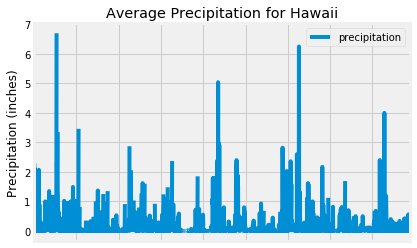

In [13]:
# Use Pandas Plotting with Matplotlib to plot the data

ax = last_year_precipitation_df.plot()
ax.xaxis.set_major_formatter(plt.NullFormatter()) # removes the dates from the x axis
plt.title("Average Precipitation for Hawaii")
plt.ylabel("Precipitation (inches)")
plt.xlabel("") 

# Save plot

plt.savefig("Output/Average Precipitation by Date.png", index=False, header=True)


In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
last_year_precipitation_df.describe()

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


## Station Analysis

In [15]:
# Design a query to show how many stations are available in this dataset?
station_query = session.query(Measurement.station).distinct().count()
print(f' {station_query} stations available')


 9 stations available


In [16]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_count_query = session.query(Measurement.id, Measurement.station, func.count(Measurement.id)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.id).desc()).all()

station_count_query_df = pd.DataFrame(station_count_query, columns=['station id', 'station','observations'])
station_count_query_df


,station id,station,observations
0,12188,USC00519281,2772
1,1,USC00519397,2724
2,2725,USC00513117,2709
3,9519,USC00519523,2669
4,16939,USC00516128,2612
5,5434,USC00514830,2202
6,14960,USC00511918,1979
7,7636,USC00517948,1372
8,9008,USC00518838,511


In [17]:
    print(f'station with most observations:{station_count_query[0]}')


station with most observations:(12188, 'USC00519281', 2772)


In [18]:
# Using the station id from the previous query, calculate: 
    #A) the lowest temperature recorded: 

station_USC00519281_min = session.query(func.min(Measurement.tobs)).\
    filter(Measurement.station == 'USC00519281').all()
print(f'Station id 12188 minimum recorded temperature was {station_USC00519281_min}')


Station id 12188 minimum recorded temperature was [(54.0,)]


In [19]:
    #B) the highest temperature recorded:

station_USC00519281_max = session.query(func.max(Measurement.tobs)).\
    filter(Measurement.station == 'USC00519281').all()
print(f'Station id 12188 highest recorded temperature was {station_USC00519281_max}')



Station id 12188 highest recorded temperature was [(85.0,)]


In [20]:
    #C) the average temperature:
station_USC00519281_avg = session.query(func.avg(Measurement.tobs)).\
    filter(Measurement.station == 'USC00519281').all()
    
print(f'Station id 12188 average recorded temperature was {station_USC00519281_avg}')





Station id 12188 average recorded temperature was [(71.66378066378067,)]


In [21]:
# Choose the station with the highest number of temperature observations.
highest_temp_obs = session.query(Measurement.id, Measurement.station, func.count(Measurement.tobs)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.tobs).desc()).first()
highest_temp_obs_station = highest_temp_obs[0]
print(f'Highest # (of temperature observations) occurs at station {highest_temp_obs_station}')


Highest # (of temperature observations) occurs at station 12188


In [22]:
#Query the last 12 months of temperature observation data for this station
T_obs = session.query(Measurement.tobs).\
    filter(Measurement.date >= one_year_ago).\
    filter(Measurement.station == 'USC00519281').all()

T_obs_df = pd.DataFrame(T_obs, columns=['TEMP']) 
T_obs_df.head()

,TEMP
0,77.0
1,80.0
2,80.0
3,75.0
4,73.0


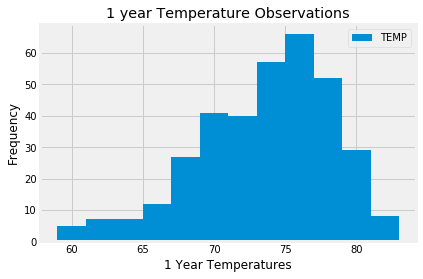

In [23]:
# Plot the results as a histogram 
T_obs_df.plot.hist(bins=12, title = '1 year Temperature Observations' )

plt.xlabel('1 Year Temperatures')
plt.savefig('One_Year_Temp_Obs.png')


In [24]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
def calc_temps(start_date_, end_date):
    """Annual TMIN, TAVG, and TMAX 
    
    Args:
        start_date (string): formatted %Y-%m-%d
        end_date (string): formatted %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).\
        filter(Measurement.date <= end_date).all()


In [33]:
#Prompt user to enter trip information into dialog boxes:
start_date = input('Please select your trips start date ("YYYY-MM-DD") between 2010-01-01 and 2017-08-23: ')
     
end_date = input('Please select your trips end date ("YYYY-MM-DD") and between 2010-01-01 and 2017-08-23: ')


year_calc_temps = calc_temps('{start_date}', '{end_date}')
print('1 year weather data (Aug 2016 through Aug 2017),')
print(f'The estimated min, avg, and max temperatures for {start_date} to {end_date}: ')

# Create a DataFrame with t_min, t_avg, t_max values from vacation_temps
year_temps_df = pd.DataFrame(year_calc_temps, columns=['min_temp', 'avg_temp', 'max_temp'])
year_temps_df

Please select your trips start date ("YYYY-MM-DD") between 2010-01-01 and 2017-08-23: 2016-02-28
Please select your trips end date ("YYYY-MM-DD") and between 2010-01-01 and 2017-08-23: 2016-03-07
1 year weather data (Aug 2016 through Aug 2017),
The estimated min, avg, and max temperatures for 2016-02-28 to 2016-03-07: 


,min_temp,avg_temp,max_temp
0,58.0,74.622647,87.0


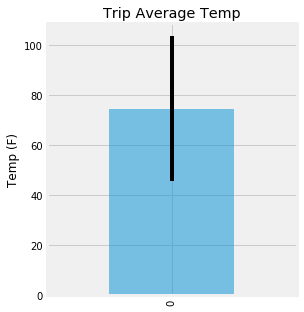

In [26]:
# Plot the results from your previous query as a bar chart.
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
year_temps_df.plot.bar(y='avg_temp', yerr = (year_temps_df['max_temp'] - year_temps_df['min_temp']),\
                                title='Trip Average Temp', alpha=.5, figsize=(4,5), legend=None)
# Set plot properties
plt.ylabel('Temp (F)')
plt.savefig('Output/Trip Avg Temp.png')


In [34]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
def precip (prcp_start_date, prcp_end_date):
    """Precipitation information per weather station.
    
    Args:
        prcp_start_date (string): formatted %Y-%m-%d
        prcp_end_date (string):  formatted %Y-%m-%d
        
    Returns tuple:
        precipitation amount, station, name, latitude, longitude, and elevation.
    """
    
    sel = [Measurement.station,
             Station.name,
             Station.latitude,
             Station.longitude,
             Station.elevation,
             Measurement.prcp]
      
    return session.query(*sel).\
            filter(Measurement.station == Station.station).\
            filter(Measurement.date >= prcp_start_date).\
            filter(Measurement.date <= prcp_end_date).\
            group_by(Measurement.station).\
            order_by(Measurement.prcp.desc()).all()

In [35]:
#Prompt user to enter trip information into dialog boxes:
start_date = input('Please select your trips start date ("YYYY-MM-DD") between 2010-01-01 and 2017-08-23: ')
end_date = input('Please select your trips end date ("YYYY-MM-DD") and between 2010-01-01 and 2017-08-23: ')
print('1 year weather data (Aug 2016 through Aug 2017),')
print(f'The estimated total amount of rainfall for {start_date} to {end_date}: ')

#Create a dataframe with station name, lat/long, elevation and precipitation:
precip_df = pd.DataFrame(precip('2016-02-28', '2016-03-05'), columns=['station_id','station_name', 'latitude', 'longitude', 'elevation', 'precipitation'])
precip_df

Please select your trips start date ("YYYY-MM-DD") between 2010-01-01 and 2017-08-23: 2016-02-28
Please select your trips end date ("YYYY-MM-DD") and between 2010-01-01 and 2017-08-23: 2016-03-07
1 year weather data (Aug 2016 through Aug 2017),
The estimated total amount of rainfall for 2016-02-28 to 2016-03-07: 


,station_id,station_name,latitude,longitude,elevation,precipitation
0,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,0.0
1,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,0.0
2,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,0.0
3,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,0.0
4,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.0
5,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.0
6,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,NaN


## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)



In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
